# Sinogram Denoiser (Sinusoidal Patching) Using Mayo Clinical Images

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import warnings
warnings.filterwarnings('ignore')

import odl
import odlpet
from odlpet.scanner.scanner import Scanner
from odlpet.scanner.compression import Compression
from odl.contrib.torch import OperatorModule
from odl.contrib import fom


import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.nn.parallel import DataParallel as DP
from torch.utils.data import Dataset
torch.backends.cudnn.benchmark = True
import torch.nn.functional as F

from array_api_compat import to_device
from array_api_compat import device
import array_api_compat.torch as xp


# import parallelproj

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(2)

In [2]:
# Create ODL data structures
size = 512
space = odl.uniform_discr([-128, -128], [128, 128], [size, size],
                          dtype='float32', weighting=1.0)

# Tomography
# Make a fan beam geometry with flat detector
# Angles: uniformly spaced, n = 360, min = 0, max = 2 * pi
angle_partition = odl.uniform_partition(0, 2 * np.pi, 1000)
detector_partition = odl.uniform_partition(-360, 360, 1000)
#geometry = odl.tomo.FanFlatGeometry(angle_partition, detector_partition, src_radius=500, det_radius=500)
geometry = odl.tomo.FanBeamGeometry(angle_partition, detector_partition, src_radius=500, det_radius=500)



ray_transform = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(ray_transform)
operator = (1 / opnorm) * ray_transform


pseudoinverse = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.45)

# User selected paramters
mu_water = 0.02
photons_per_pixel = 1000

In [3]:
#image_true_training_np = np.load('/mnt/imagingnas/data/Users/mct/PET/hamidreza/mayo/image_true_training_HU.npy')
#sino_true_training_np = np.load('/mnt/imagingnas/data/Users/mct/PET/hamidreza/mayo/sino_true_training_HU.npy')
#sino_noisy_training_np = np.load('/mnt/imagingnas/data/Users/mct/PET/hamidreza/mayo/sino_noisy_training_HU.npy')

sino_true_training_np = np.load('/mnt/datahd/Hamidreza/Mayo_data/sino_true_training_HU_new.npy')
sino_noisy_training_np = np.load('/mnt/datahd/Hamidreza/Mayo_data/sino_noisy_training_HU_new.npy')



# Combine the arrays along a new axis
combined = list(zip(sino_noisy_training_np, sino_true_training_np))

# image_true_training_torch = torch.tensor(image_true_training_np)
# sino_true_training_torch = torch.tensor(sino_true_training_np)
# sino_noisy_training_torch = torch.tensor(sino_noisy_training_np)

del sino_true_training_np
del sino_noisy_training_np

In [4]:
def shuffle_data(combined_data):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    # Split the combined data back into sino_noisy and sino_true
    sino_noisy_shuffled, sino_true_shuffled = zip(*combined_data)
    return torch.tensor(np.array(sino_noisy_shuffled)) , torch.tensor(np.array(sino_true_shuffled))

In [5]:
combined[0][0].shape

(1000, 1000)

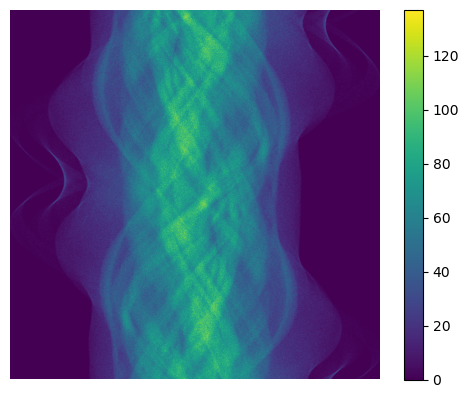

In [6]:
plt.imshow(combined[0][0])
plt.colorbar()
ax = plt.gca()
ax.set_axis_off()

In [7]:
len(combined)

2168

In [8]:
# Function to compute patch indices and related data
def get_indices(patch_size, s=0, dev='cuda'):
    """
    Generate patch-based indices and related data for an image and its sinograms.

    Args:
        patch_size (tuple): The size of each patch (height, width).
        s (float): Threshold for filtering log-transformed data.
        dev (str): Device to use (e.g., 'cuda' or 'cpu').

    Returns:
        tuple: Contains stacked tensor, last index, list of indices, lengths, 
               max length, last tensor, padded tensors, image grid, and sinograms.
    """
    # Set image shape (height, width)
    image_shape = (512, 512)

    # Check if the image dimensions are divisible by the patch size
    if image_shape[0] % patch_size[0] != 0 or image_shape[1] % patch_size[1] != 0:
        raise ValueError("Image dimensions must be divisible by the patch size.")

    # Calculate the number of patches in each dimension
    num_patches_grid = (
        int(np.ceil(image_shape[0] / patch_size[0])),
        int(np.ceil(image_shape[1] / patch_size[1]))
    )

    # Initialize arrays for images and sinograms
    num_patches = num_patches_grid[0] * num_patches_grid[1]
    images = np.zeros((num_patches, image_shape[0], image_shape[1]))
    sinos = np.zeros((num_patches, 1000, 1000))
    indices = []

    # Process each patch
    for k in range(num_patches):
        i = k // num_patches_grid[1]  # Row index of the patch grid
        j = k % num_patches_grid[1]  # Column index of the patch grid

        # Create a binary mask for the current patch
        images[k, 
               i * patch_size[0]:(i + 1) * patch_size[0],
               j * patch_size[1]:(j + 1) * patch_size[1]] = 1

        # Generate a phantom from the binary mask
        phantom = space.element(images[k])  # Assumes `space` is defined elsewhere
        phantom /= 1000.0  # Normalize phantom to g/cm^3

        # Perform ray transform and apply corrections
        data = ray_transform(phantom)  # Assumes `ray_transform` is defined
        data = np.exp(-data * mu_water)  # Convert to attenuation data
        log_data = np.log(data) * (-1 / mu_water) * (1 / opnorm)  # Log transform with scaling

        # Store the log-transformed sinograms
        sinos[k] = log_data

        # Find indices above the threshold `s`
        index = (torch.tensor(log_data).unsqueeze(0).unsqueeze(1) > s).nonzero()
        indices.append(index)

    # Calculate the maximum length of the index tensors
    lengths = [len(tensor) for tensor in indices]
    max_length = max(lengths)

    # Pad tensors to ensure uniform length
    padded_tensors = []
    for tensor in indices:
        pad_size = max_length - len(tensor)
        padded_tensor = F.pad(tensor, (0, 0, pad_size, 0))
        padded_tensors.append(padded_tensor)

    # Stack all padded tensors into a single tensor
    stacked_tensor = torch.stack(padded_tensors)

    # Return all generated data
    return (
        stacked_tensor, index, indices, lengths, max_length, tensor, padded_tensors, images, sinos
    )


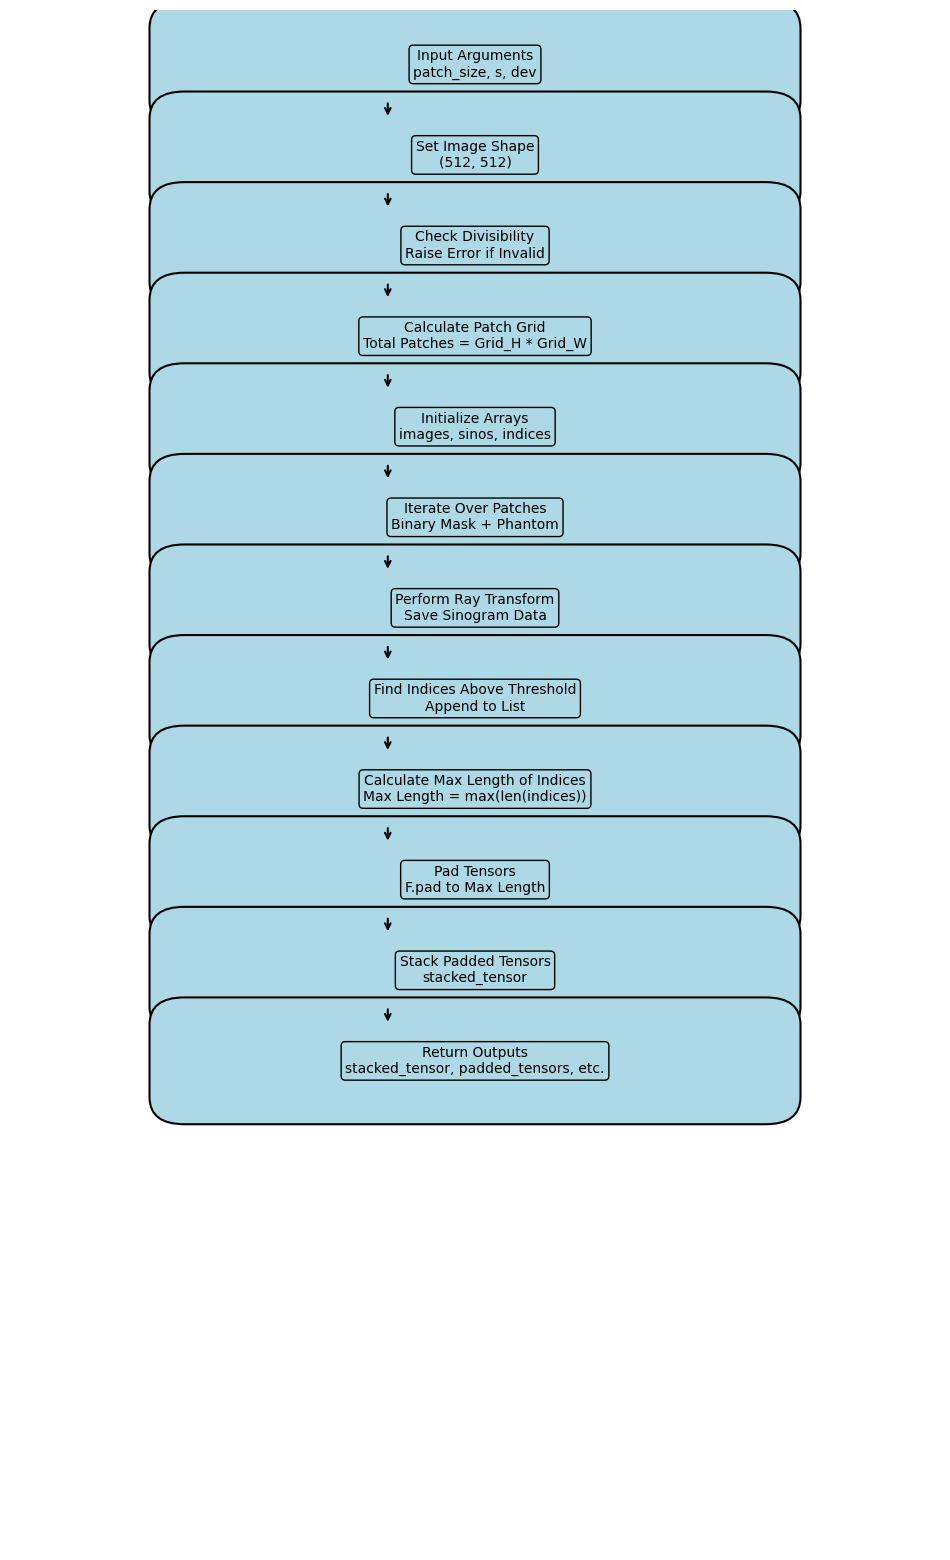

In [74]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add a block to the diagram
def add_block(ax, text, xy, width=5.0, height=0.8, boxstyle="round,pad=0.3", color='lightblue'):
    ax.text(
        xy[0] + width / 2,
        xy[1] + height / 2,
        text,
        ha='center',
        va='center',
        fontsize=10,
        bbox=dict(boxstyle=boxstyle, facecolor=color, edgecolor='black')
    )
    return FancyBboxPatch((xy[0], xy[1]), width, height, boxstyle=boxstyle, color=color, ec="black", lw=1.5)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 20))
ax.set_xlim(0, 8)
ax.set_ylim(-15, 2)
ax.axis('off')

# Define the blocks and their positions
blocks = [
    ("Input Arguments\npatch_size, s, dev", (1.5, 1)),
    ("Set Image Shape\n(512, 512)", (1.5, 0)),
    ("Check Divisibility\nRaise Error if Invalid", (1.5, -1)),
    ("Calculate Patch Grid\nTotal Patches = Grid_H * Grid_W", (1.5, -2)),
    ("Initialize Arrays\nimages, sinos, indices", (1.5, -3)),
    ("Iterate Over Patches\nBinary Mask + Phantom", (1.5, -4)),
    ("Perform Ray Transform\nSave Sinogram Data", (1.5, -5)),
    ("Find Indices Above Threshold\nAppend to List", (1.5, -6)),
    ("Calculate Max Length of Indices\nMax Length = max(len(indices))", (1.5, -7)),
    ("Pad Tensors\nF.pad to Max Length", (1.5, -8)),
    ("Stack Padded Tensors\nstacked_tensor", (1.5, -9)),
    ("Return Outputs\nstacked_tensor, padded_tensors, etc.", (1.5, -10))
]

# Add each block to the diagram
for text, xy in blocks:
    ax.add_patch(add_block(ax, text, xy))
    
# Draw arrows between blocks
for i in range(len(blocks) - 1):
    start = blocks[i][1]
    end = blocks[i + 1][1]
    ax.annotate('', xy=(start[0] + 1.75, start[1]), xytext=(end[0] + 1.75, end[1] + 0.8),
                arrowprops=dict(arrowstyle="<-", color="black", lw=1.5))

# Display the diagram
plt.show()


### Processing Flow in the `get_indices` Function

1. **Input Arguments:**
   - `patch_size`: Defines the dimensions (height, width) of each patch.
   - `s`: A threshold for filtering log-transformed sinogram data.
   - `dev`: Specifies the computational device (e.g., `'cuda'` or `'cpu'`).

2. **Set Image Shape:**
   - Fixed image dimensions are set to `(512, 512)`.

3. **Check Divisibility of Image Dimensions:**
   - Verify if the image dimensions are divisible by the patch size.  
   - Raise an error if the dimensions are not divisible.

4. **Calculate Patch Grid:**
   - Compute the number of patches along the height and width of the image grid using the patch size.  
   - Calculate the total number of patches.

5. **Initialize Arrays:**
   - Create zero-filled arrays for:
     - `images`: Stores binary masks for patches.
     - `sinos`: Stores log-transformed sinogram data.
   - Initialize an empty list `indices` to store index tensors for each patch.

6. **Iterate Over Patches:**
   - For each patch (indexed by `k`):
     - Determine its row (`i`) and column (`j`) position in the patch grid.
     - Create a binary mask for the current patch and store it in `images`.
     - Generate a phantom from the binary mask (assumes `space` is pre-defined).
     - Normalize the phantom by dividing by 1000.

7. **Perform Ray Transform:**
   - Compute the ray transform of the phantom (assumes `ray_transform` is pre-defined).

8. **Store Sinograms:**
   - Save the log-transformed sinogram data for the current patch in `sinos`.

9. **Find Indices Above Threshold:**
   - Identify indices in the sinogram data where values exceed the threshold `s`.
   - Append these indices to the `indices` list.

10. **Calculate Max Length of Indices:**
    - Compute the lengths of all index tensors in the `indices` list.
    - Determine the maximum length among them.

11. **Pad Tensors:**
    - Pad each index tensor in `indices` to match the maximum length.
    - Use `F.pad` to add padding and store the padded tensors in a new list `padded_tensors`.

12. **Stack Padded Tensors:**
    - Stack all padded tensors into a single tensor `stacked_tensor`.

13. **Return Outputs:**
    - The function returns the following:
        - `stacked_tensor`: Tensor containing all padded indices.
        - `index`: The indices for the last processed patch.
        - `indices`: List of raw indices for each patch.
        - `lengths`: List of lengths of index tensors.
        - `max_length`: The maximum length of the indices.
        - `tensor`: The last padded tensor.
        - `padded_tensors`: List of padded tensors.
        - `images`: Array containing binary masks for all patches.
        - `sinos`: Array of log-transformed sinograms for all patches.


In [9]:
# import torch.nn.functional as F

# def get_indices(patch_size, s=0, dev='cuda'):
    
#     image_shape = (512, 512)

#     num_patches_grid = (int(np.ceil(image_shape[0]/patch_size[0])), int(np.ceil(image_shape[1]/patch_size[1])))
#     images = np.zeros((num_patches_grid[0]*num_patches_grid[1], image_shape[0], image_shape[1]))
#     sinos = np.zeros((num_patches_grid[0]*num_patches_grid[1], 1000, 1000))
#     indices = []

#     num_patches = num_patches_grid[0]*num_patches_grid[1]
#     for k in range(num_patches):
#         i = k // num_patches_grid[1]
#         j = k % num_patches_grid[1]
#         images[k, i*patch_size[0]:(i+1)*patch_size[0], j*patch_size[1]:(j+1)*patch_size[1]] = 1
#         #plt.imshow(images[k])
#         phantom = space.element(images[k])
#         phantom /= 1000.0  # convert go g/cm^3

#         data = ray_transform(phantom)
#         data = np.exp(-data * mu_water)
#         log_data = np.log(data)* (-1 / mu_water) * (1 / opnorm)
#         sinos[k] = np.log(data)* (-1 / mu_water) * (1 / opnorm)
#         index = (torch.tensor(torch.tensor(log_data.asarray()).unsqueeze(0).unsqueeze(1)) > s).nonzero()
#         indices.append(index)

#     lengths = [len(tensor) for tensor in indices]
#     max_length = max(lengths)

#     padded_tensors = []
#     for tensor in indices:
#         pad_size = max_length - len(tensor)
#         padded_tensor = F.pad(tensor, (0, 0, pad_size, 0))
#         padded_tensors.append(padded_tensor)
    
#     stacked_tensor = torch.stack(padded_tensors)

#     return stacked_tensor, index, indices, lengths, max_length, tensor, padded_tensors, images, sinos

In [10]:
get_indices((128, 128), s=0)[0].shape

torch.Size([16, 235575, 4])

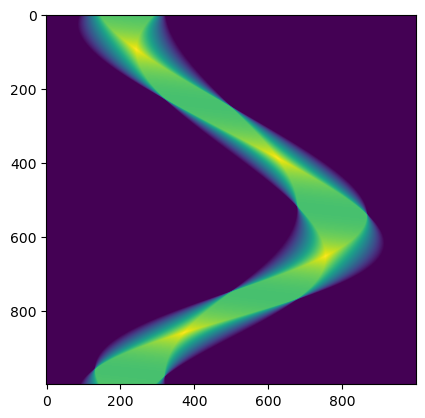

In [11]:
plt.imshow(get_indices((128, 128), s=0)[8][1])

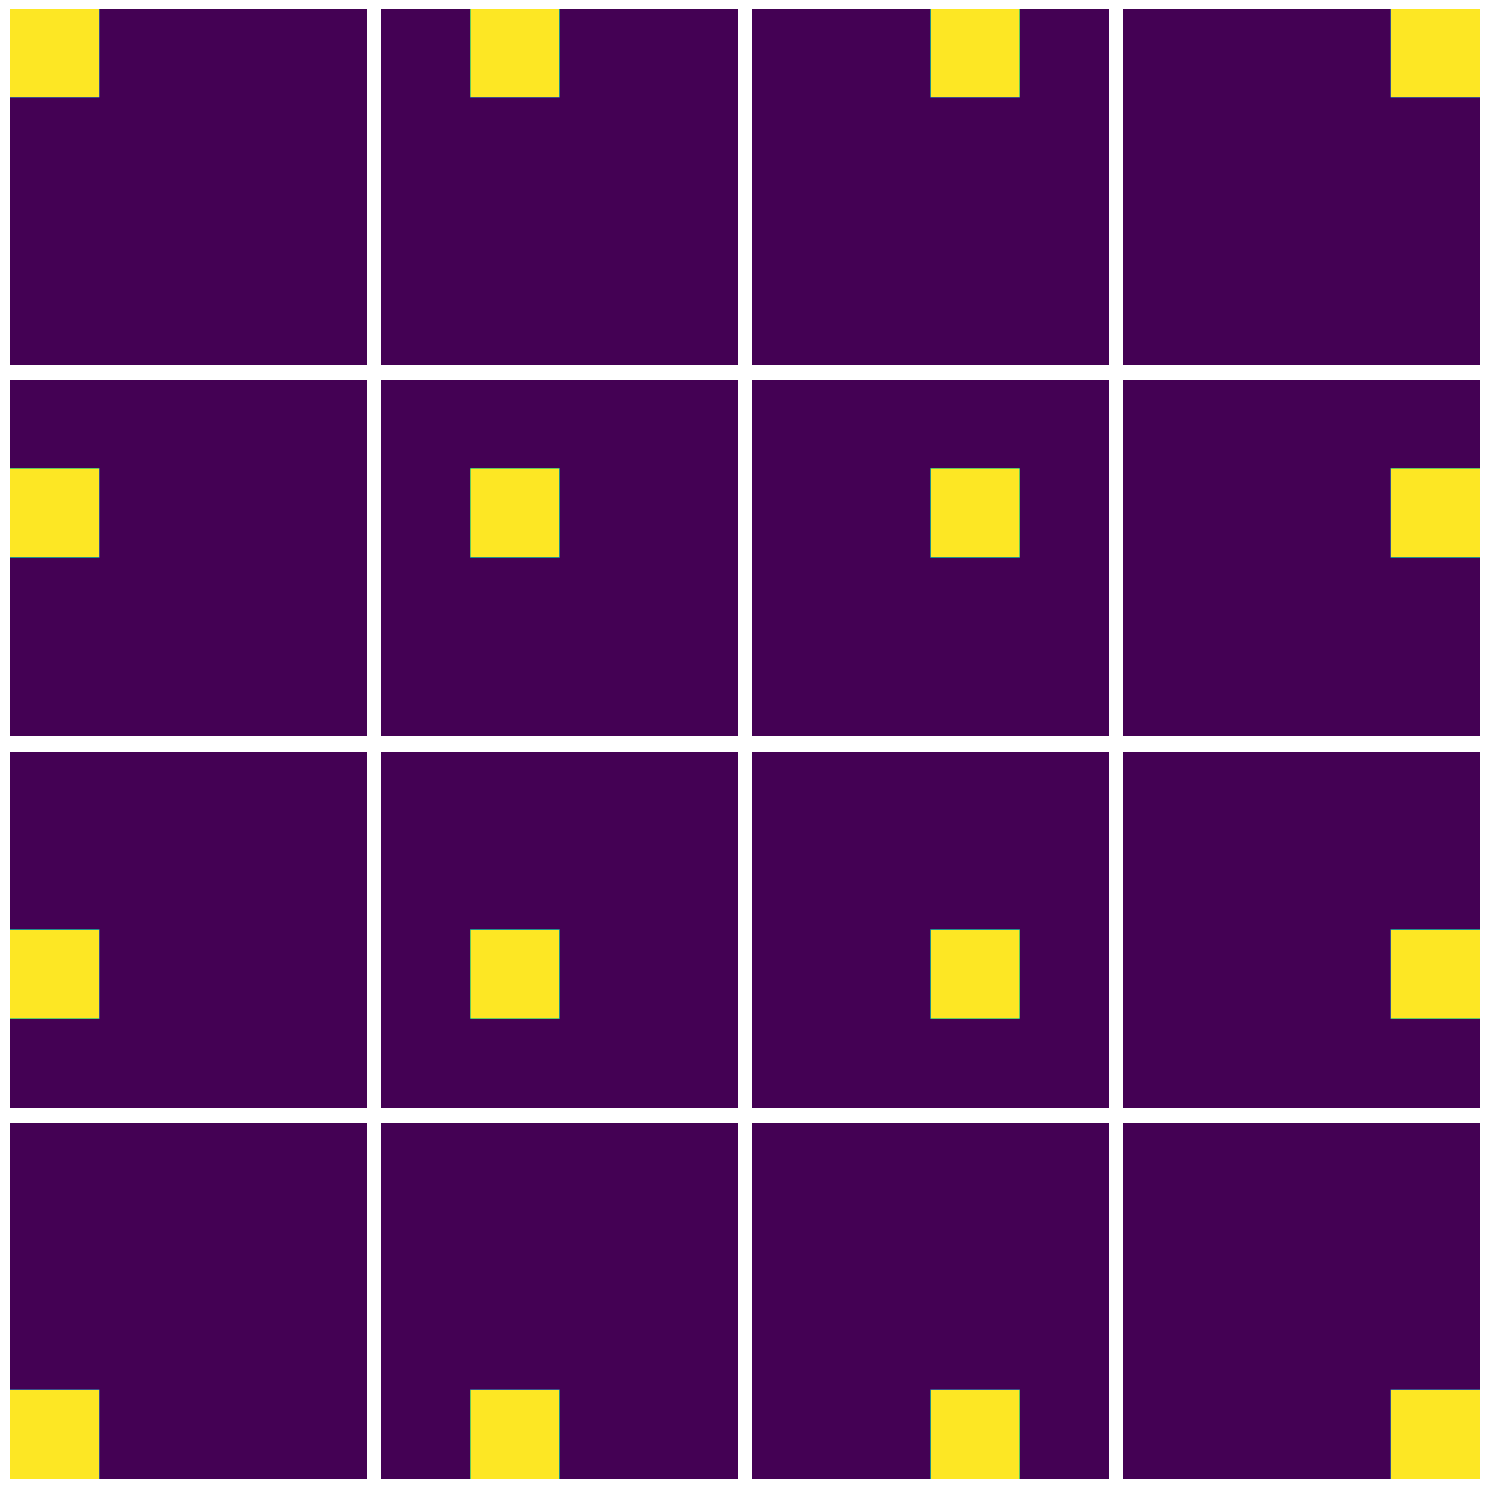

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Plot each image in the subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(get_indices((128, 128), s=0)[7][i])
    ax.axis('off')  # Hide the axis

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

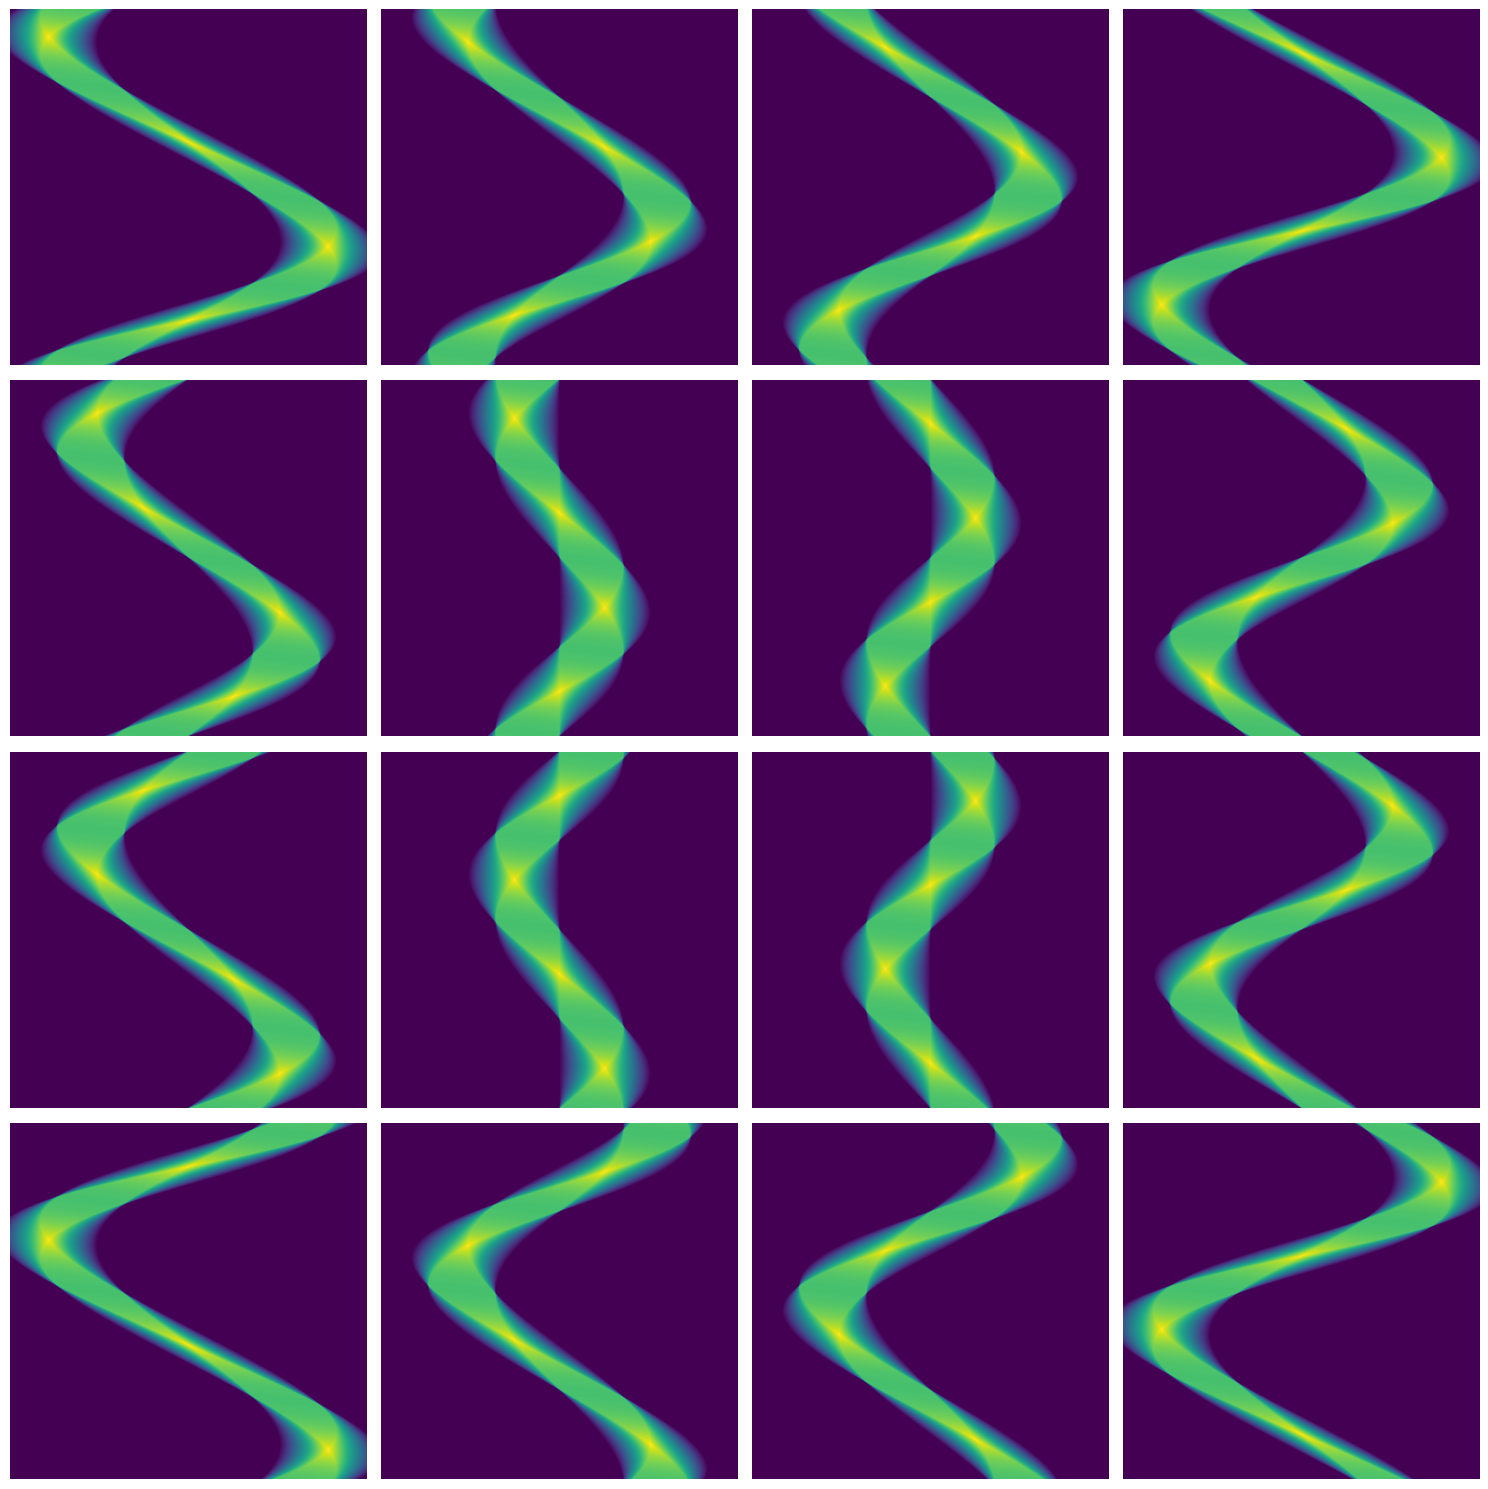

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Plot each image in the subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(get_indices((128, 128), s=0)[8][i])
    ax.axis('off')  # Hide the axis

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [14]:
# get_indices((128, 128), s=0)[0].shape

In [15]:
# (get_indices((128, 128), s=0)[1]).shape

In [16]:
# len(get_indices((128, 128), s=0)[2])

In [17]:
# get_indices((128, 128), s=0)[2][15].shape

In [18]:
# get_indices((128, 128), s=0)[3]

In [19]:
# get_indices((128, 128), s=0)[4]

In [20]:
# get_indices((128, 128), s=0)[5].shape

In [21]:
# get_indices((128, 128), s=0)[6][15].shape

In [22]:
batch_size = 8
num_epochs = 5

In [23]:
# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Residual Block for building deep neural networks.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add shortcut connection
        out = self.relu(out)
        return out

# Transformer Definition
class Transformer(nn.Module):
    def __init__(self, head_dim=32, heads=6, dropout=0.3):
        """
        Transformer block for self-attention and MLP layers.

        Args:
            head_dim (int): Dimension of each attention head.
            heads (int): Number of attention heads.
            dropout (float): Dropout rate.
        """
        super(Transformer, self).__init__()
        self.head_dim = head_dim
        self.heads = heads
        self.embedding_dim = heads * head_dim

        self.softmax = nn.Softmax(dim=-1)
        self.Q = nn.Linear(self.embedding_dim, head_dim * heads, bias=False)
        self.K = nn.Linear(self.embedding_dim, head_dim * heads, bias=False)
        self.V = nn.Linear(self.embedding_dim, head_dim * heads, bias=False)

        self.mlp = nn.Sequential(
            nn.Linear(self.embedding_dim, self.embedding_dim),
            nn.ReLU(),
            nn.Linear(self.embedding_dim, self.embedding_dim),
            nn.ReLU()
        )

        self.layernorm = nn.LayerNorm(self.embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, Z):
        Q, K, V = self.Q(Z), self.K(Z), self.V(Z)
        attention = self.dropout(torch.matmul(self.softmax(torch.matmul(Q, K.transpose(-1, -2)) * self.head_dim ** -0.5), V))

        x = self.layernorm(attention + Z)
        x = self.dropout(self.mlp(x))
        return x

# Transformer Block Definition
class TransformerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, img_shape, indices, head_dim=32, heads=6):
        """
        Transformer block integrated with residual connections for image processing.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            img_shape (tuple): Shape of the input image (height, width, depth).
            indices (torch.Tensor): Indices for patch-based operations.
            head_dim (int): Dimension of each attention head.
            heads (int): Number of attention heads.
        """
        super(TransformerBlock, self).__init__()

        self.head_dim = head_dim
        self.heads = heads
        self.embedding_dim = heads * head_dim
        self.im_h, self.im_w, self.im_d = img_shape
        self.in_channels = in_channels
        self.indices = indices
        self.num_patches = indices.shape[0]
        self.patch_dim = indices.shape[1]

        # Flattening layer for patch embeddings
        self.flatten = Rearrange('b c p v s -> (b s) (c p) v')

        # Linear transformation and normalization for patch embeddings
        self.H = nn.Sequential(
            nn.Linear(self.patch_dim, self.embedding_dim),
            nn.LayerNorm(self.embedding_dim)
        )

        # Positional encodings
        self.positional_encodings = nn.Parameter(torch.randn(self.num_patches * self.in_channels, self.embedding_dim))

        # Tail block for transforming embeddings back
        self.tail = nn.Sequential(
            nn.Linear(self.embedding_dim, self.patch_dim),
            nn.ReLU(),
            Rearrange('(b s) (c p) v -> b c p v s', p=self.num_patches, s=self.im_d)
        )

        # Residual block for enhancing features
        self.residualBlock = nn.Sequential(
            Rearrange('b c h w s -> (b s) c h w'),
            ResidualBlock(in_channels, out_channels),
            Rearrange('(b s) c h w -> b c h w s', s=self.im_d)
        )

        # Transformer layers
        self.layers = nn.Sequential(Transformer(), Transformer())

    def forward(self, sino):
        
        # print('sino shape is', sino.shape)
        
        sino = sino.unsqueeze(-1)  # Add an extra dimension for compatibility
        # print('sino shape is', sino.shape)
        
        encodings = sino[:, :, self.indices[:, :, 0], self.indices[:, :, 1], :]
        # print('encodings shape is', encodings.shape)
        
        encodings = self.flatten(encodings)  # Flatten patch embeddings
        # print('encodings shape is', encodings.shape)
        
        H = self.H(encodings)  # Transform and normalize patches
        # print('H shape is', H.shape)
        
        Z = H + self.positional_encodings.repeat(sino.shape[-1] * sino.shape[0], 1, 1)  # Add positional encodings
        # print('Z shape is', Z.shape)
        
        Z = self.layers(Z)  # Apply transformer layers
        # print('Z shape is', Z.shape)
        
        out = self.tail(Z)  # Transform back to original shape
        # print('out shape is', out.shape)
        
        # Update sinogram with residual connection
        sino_clone = sino.clone()
        # print('sino_clone shape is', sino_clone.shape)
        sino_clone[:, :, self.indices[:, :, 0], self.indices[:, :, 1], :] += out.clone()
        sino = sino_clone
        # print('sino shape is', sino.shape)

        sino = self.residualBlock(sino)  # Apply residual block
        # print('sino shape is', sino.shape)
        
        return sino.squeeze(-1)


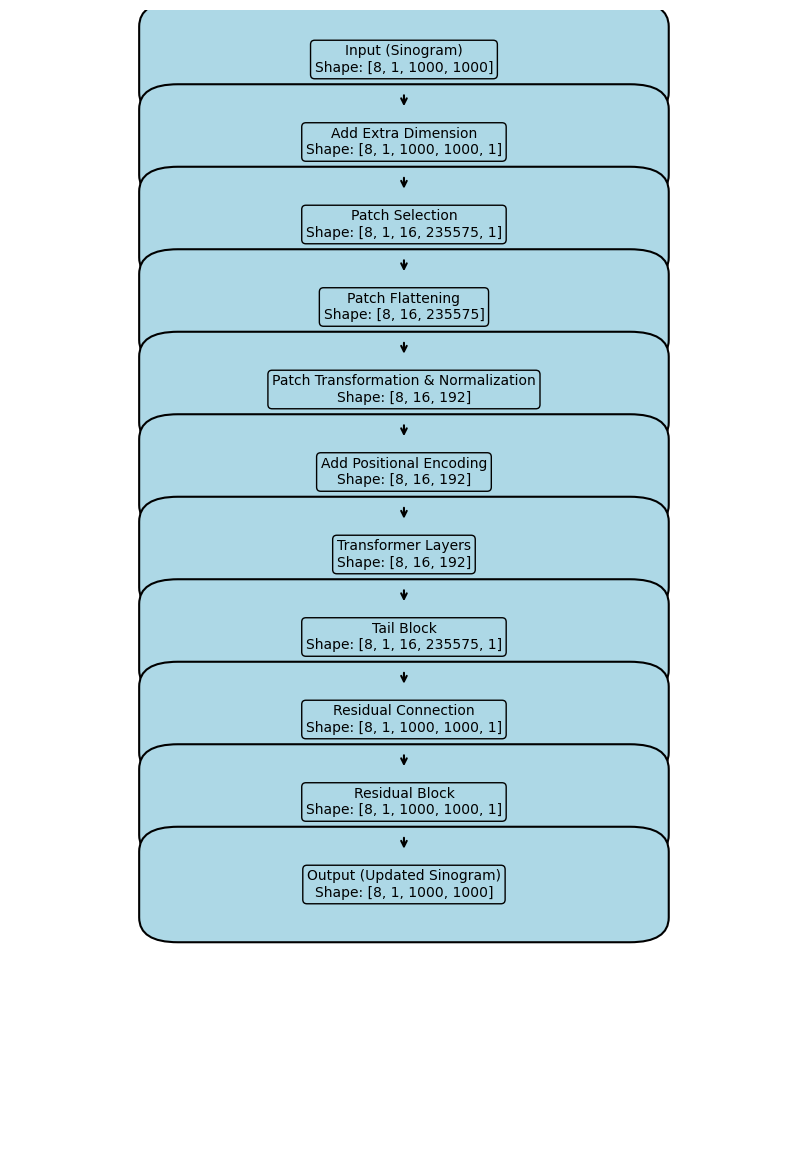

In [63]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to add a block to the diagram
def add_block(ax, text, xy, width=3.5, height=0.8, boxstyle="round,pad=0.3", color='lightblue'):
    ax.text(
        xy[0] + width / 2,
        xy[1] + height / 2,
        text,
        ha='center',
        va='center',
        fontsize=10,
        bbox=dict(boxstyle=boxstyle, facecolor=color, edgecolor='black')
    )
    return FancyBboxPatch((xy[0], xy[1]), width, height, boxstyle=boxstyle, color=color, ec="black", lw=1.5)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 15))
ax.set_xlim(0, 6)
ax.set_ylim(-12, 2)
ax.axis('off')

# Define the blocks and their positions
blocks = [
    ("Input (Sinogram)\nShape: [8, 1, 1000, 1000]", (1.3, 1)),
    ("Add Extra Dimension\nShape: [8, 1, 1000, 1000, 1]", (1.3, 0)),
    ("Patch Selection\nShape: [8, 1, 16, 235575, 1]", (1.3, -1)),
    ("Patch Flattening\nShape: [8, 16, 235575]", (1.3, -2)),
    ("Patch Transformation & Normalization\nShape: [8, 16, 192]", (1.3, -3)),
    ("Add Positional Encoding\nShape: [8, 16, 192]", (1.3, -4)),
    ("Transformer Layers\nShape: [8, 16, 192]", (1.3, -5)),
    ("Tail Block\nShape: [8, 1, 16, 235575, 1]", (1.3, -6)),
    ("Residual Connection\nShape: [8, 1, 1000, 1000, 1]", (1.3, -7)),
    ("Residual Block\nShape: [8, 1, 1000, 1000, 1]", (1.3, -8)),
    ("Output (Updated Sinogram)\nShape: [8, 1, 1000, 1000]", (1.3, -9))
]

# Add each block to the diagram
for text, xy in blocks:
    ax.add_patch(add_block(ax, text, xy))

# Draw arrows between blocks
for i in range(len(blocks) - 1):
    start = blocks[i][1]
    end = blocks[i + 1][1]
    ax.annotate('', xy=(start[0] + 1.75, start[1]), xytext=(end[0] + 1.75, end[1] + 0.8),
                arrowprops=dict(arrowstyle="<-", color="black", lw=1.5))

# Display the diagram
plt.show()


# Processing Flow in the Forward Path of the TransformerBlock:

0. **Input (Sinogram):**

   The sinogram (sino) is received.  
   Initial shape: `torch.Size([8, 1, 1000, 1000])`

1. **Adding an Extra Dimension for Compatibility:**

   An extra dimension is added to the sinogram to match the expected input shape of subsequent layers.  
   Updated shape: `torch.Size([8, 1, 1000, 1000, 1])`

2. **Patch Selection:**

   Patches are extracted based on pre-defined indices (`self.indices`).  
   Shape after patch selection: `torch.Size([8, 1, 16, 235575, 1])`

3. **Patch Flattening:**

   The patches are flattened using a `Rearrange` layer to create patch embeddings.  
   Shape after flattening: `torch.Size([8, 16, 235575])`

4. **Patch Transformation & Normalization:**

   The flattened patches are passed through a linear layer (`self.H`) for dimensionality reduction and normalized using `LayerNorm`.  
   Shape after transformation: `torch.Size([8, 16, 192])`

5. **Positional Encoding:**

   Positional encodings are added to the transformed patches to provide spatial context for each patch.  
   Shape with positional encodings: `torch.Size([8, 16, 192])`

6. **Transformer Layers:**

   The patches with positional encodings are processed through transformer layers, which include self-attention and a multi-layer perceptron (MLP).  
   Shape after transformer layers: `torch.Size([8, 16, 192])`

7. **Tail Block:**

   The output from the transformer layers is processed through the Tail Block, reconstructing the original patch dimensions.  
   Shape after Tail Block: `torch.Size([8, 1, 16, 235575, 1])`

8. **Residual Connection:**

   The Tail Block output is added back to the original sinogram using a residual connection.  
   Shape after residual connection: `torch.Size([8, 1, 1000, 1000, 1])`

9. **Residual Block:**

   The result is refined through a Residual Block, which applies convolution, batch normalization, and ReLU activation.  
   Shape after refinement: `torch.Size([8, 1, 1000, 1000, 1])`

10. **Output (Updated Sinogram):**

    The final updated sinogram is returned after all the transformations.  
    Final shape: `torch.Size([8, 1, 1000, 1000])`

In [25]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = self.relu(out)
#         return out

# class Transformer(nn.Module):
#   def __init__(self, head_dim=32, heads=6, dropout=0.3):
#     super(Transformer, self).__init__()
#     self.head_dim = head_dim
#     self.heads = heads
#     self.embedding_dim = heads*head_dim
  
#     self.softmax = nn.Softmax(dim=-1)
#     self.Q = nn.Linear(self.embedding_dim, head_dim*heads, bias=False)
#     self.K = nn.Linear(self.embedding_dim, head_dim*heads, bias=False)
#     self.V = nn.Linear(self.embedding_dim, head_dim*heads, bias=False)
    
#     self.mlp = nn.Sequential(nn.Linear(self.embedding_dim, self.embedding_dim), nn.ReLU(),
#                              nn.Linear(self.embedding_dim, self.embedding_dim), nn.ReLU())

#     self.layernorm = nn.LayerNorm(heads*head_dim)
#     self.dropout = nn.Dropout(dropout)

#   def forward(self,Z):
#     Q, K, V = self.Q(Z), self.K(Z), self.V(Z)
#     attention = self.dropout(torch.matmul(self.softmax(torch.matmul(Q, K.transpose(-1, -2)) * self.head_dim ** -0.5),V))
    
#     x = self.layernorm(attention+Z)
#     x = self.dropout(self.mlp(x))
#     return x

# class TransformerBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, img_shape, indices, head_dim=32, heads=6):
#         super(TransformerBlock, self).__init__()

#         self.head_dim = head_dim
#         self.heads = heads
#         self.embedding_dim = heads*head_dim
#         self.im_h, self.im_w, self.im_d = img_shape
#         self.in_channels = in_channels
#         self.indices = indices
#         self.num_patches = indices.shape[0]
#         self.patch_dim = indices.shape[1]

#         self.flatten = Rearrange('b c p v s -> (b s) (c p) v')

#         self.H = nn.Sequential(
#             nn.Linear(self.patch_dim, self.embedding_dim),
#             nn.LayerNorm(self.embedding_dim)
#         )

#         self.positional_encodings = nn.Parameter(torch.randn(self.num_patches*self.in_channels, self.embedding_dim))

#         self.tail = nn.Sequential(nn.Linear(self.embedding_dim, self.patch_dim), 
#                                   nn.ReLU(),
#                                   Rearrange('(b s) (c p) v -> b c p v s', p = self.num_patches, s=self.im_d))
        
        
#         self.residualBlock = nn.Sequential(Rearrange('b c h w s -> (b s) c h w'),
#                                            ResidualBlock(in_channels, out_channels),
#                                            Rearrange('(b s) c h w -> b c h w s', s=self.im_d))
        
#         self.layers = nn.Sequential(Transformer(),Transformer())

#     def forward(self, sino):
#       #print(sino.shape)
#       #sino = sino.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
#       sino = sino.unsqueeze(-1)
#       encodings = sino[:,:,self.indices[:,:,0],self.indices[:,:,1],:]
#       #print(encodings.shape)
#       encodings = self.flatten(encodings)
#       #print(encodings.shape)
#       H = self.H(encodings)
#       Z = H + self.positional_encodings.repeat(sino.shape[-1]*sino.shape[0],1,1)

#       Z = self.layers(Z)

#       out = self.tail(Z)

#       out_clone = out.clone()
#       sino_clone = sino.clone()

#       sino_clone[:,:,self.indices[:,:,0],self.indices[:,:,1],:] = sino[:,:,self.indices[:,:,0],self.indices[:,:,1],:] + out_clone
#       sino = sino_clone
#       sino = self.residualBlock(sino)
      
#       return sino.squeeze(0).squeeze(0).squeeze(-1)

In [26]:
model = TransformerBlock(in_channels=1, out_channels=1, img_shape=(1000, 1000, 1), indices= get_indices((128, 128), s=0, dev='cuda')[0], head_dim=32, heads=6).to(dev)
#model = DP(TransformerBlock(in_channels=1, out_channels=1, img_shape=(1000, 1000,1), indices= get_indices((256, 256), s=0, dev='cuda'), head_dim=32, heads=6), device_ids=[0,1,2,3,4,5,6,7]).to(dev)


print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

no_decay = []
decay = []

for name, param in model.named_parameters():
    if 'weight' in name and 'batchnorm' and 'layernorm' and 'relative_bias_table' not in name:
        decay.append(param)
    else:
        no_decay.append(param)

optimizer = optim.AdamW([
    {'params': decay, 'weight_decay': 0.01},
    {'params': no_decay, 'weight_decay': 0}
], lr=5e-4)

loss_function = nn.MSELoss()
#loss_function = nn.HuberLoss()
#loss_function = nn.SmoothL1Loss()
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-3,
                                             steps_per_epoch=2168, epochs=num_epochs)

torch.cuda.empty_cache()

Number of parameters: 91,070,221


In [27]:
checkpoint_dir = '/mnt/datahd/Hamidreza/Mayo_data/Sinogram_Denoiser_Mayo'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [28]:
from torch.cuda.amp import GradScaler
# Initialize the scaler for mixed precision training
scaler = GradScaler(growth_interval=100)
loss_list = []

for epoch in range(num_epochs):
    # Shuffle the data
    sino_noisy_training_torch, sino_true_training_torch = shuffle_data(combined)

    running_loss = 0.0
    ssim_list = []
    psnr_list = []

    # Process the data in batches
    num_batches = sino_true_training_torch.shape[0] // batch_size
    
    for batch_idx in range(num_batches):
        # Get the batch data
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        sino_noisy_batch = sino_noisy_training_torch[start_idx:end_idx]
        sino_true_batch = sino_true_training_torch[start_idx:end_idx]

        # Move the batch to the device (GPU)
        sino_noisy_batch = to_device(sino_noisy_batch, dev)
        sino_true_batch = to_device(sino_true_batch, dev)

        with torch.autocast(device_type="cuda"):
            optimizer.zero_grad()
            outputs_train = model(sino_noisy_batch.unsqueeze(1))  # Add channel dimension
            loss_value = loss_function(sino_true_batch.unsqueeze(1), outputs_train)
            #loss_value = loss_function(image_true_batch.unsqueeze(1), FBP_torch(outputs_train_sino))

        scaler.scale(loss_value).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss_value.item()

        # Calculate PSNR and SSIM for each image in the batch
        for j in range(batch_size):
            psnr_list.append(fom.psnr(outputs_train[j, 0].detach().cpu(), sino_true_batch[j].cpu().numpy()))
            ssim_list.append(fom.ssim(outputs_train[j, 0].detach().cpu(), sino_true_batch[j].cpu().numpy()))

            #psnr_list.append(fom.psnr(FBP_torch(outputs_train_sino)[j, 0].detach().cpu(), image_true_batch[j].cpu().numpy()))
            #ssim_list.append(fom.ssim(FBP_torch(outputs_train_sino)[j, 0].detach().cpu(), image_true_batch[j].cpu().numpy()))

    # Average the running loss and metrics
    running_loss /= num_batches
    loss_list.append(running_loss)
    
    psnr_value = np.mean(psnr_list)
    ssim_value = np.mean(ssim_list)

    print("{}/{} - loss={:.3f}; PSNR={:.3f}; SSIM={:.3f}".format(
        epoch + 1, num_epochs, running_loss, psnr_value, ssim_value))

    # Save a checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'SD3_Augmented_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict()
        }, checkpoint_path)
        print(f'Model checkpoint saved at {checkpoint_path}')

1/5 - loss=27.554; PSNR=nan; SSIM=0.590
2/5 - loss=25.095; PSNR=nan; SSIM=0.596
3/5 - loss=24.449; PSNR=nan; SSIM=0.599
4/5 - loss=23.850; PSNR=nan; SSIM=0.602
5/5 - loss=23.312; PSNR=nan; SSIM=0.606


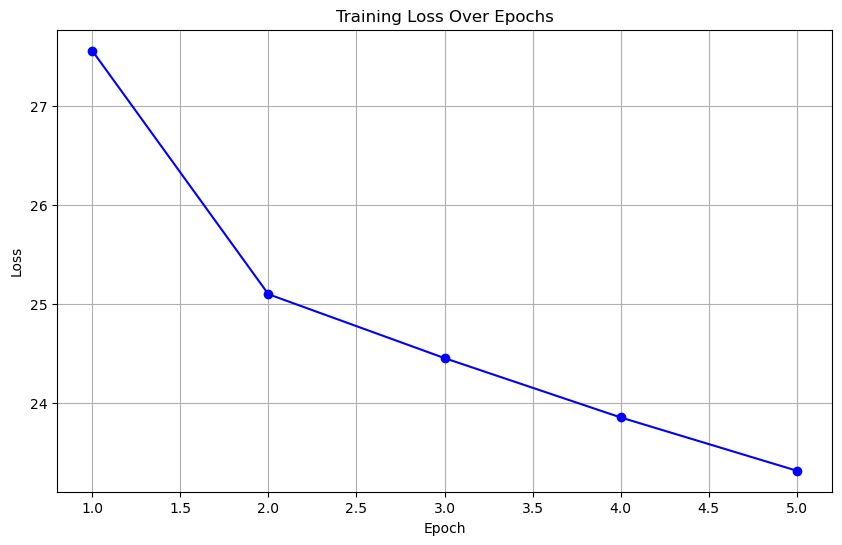

In [29]:
# Create an array for the x-axis values (epoch numbers)
epochs = list(range(1, len(loss_list) + 1))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

# Optionally add a grid
plt.grid(True)

# Show the plot
plt.show()

In [30]:
sino_noisy_training_torch.shape[0]

2168

In [31]:
outputs_train.shape

torch.Size([8, 1, 1000, 1000])

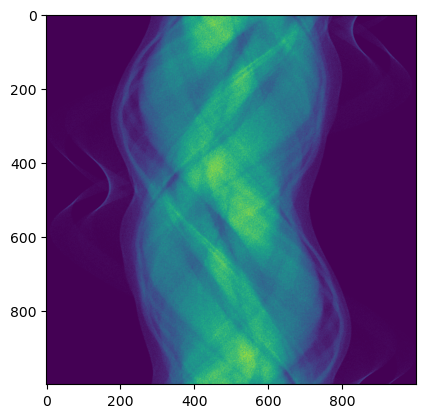

In [32]:
plt.imshow(outputs_train[1,0,:,:].detach().cpu())

In [33]:
sino_noisy_training_torch.shape

torch.Size([2168, 1000, 1000])

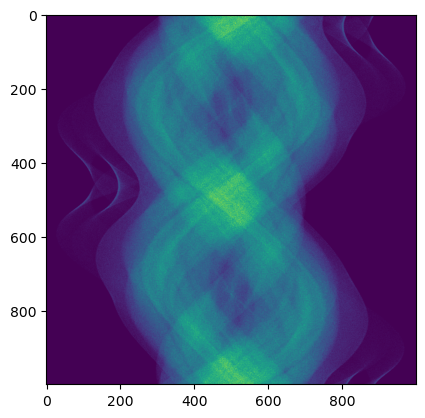

In [34]:
plt.imshow(sino_noisy_training_torch[2167,:,:].detach().cpu())

In [35]:
sino_true_training_torch.shape

torch.Size([2168, 1000, 1000])

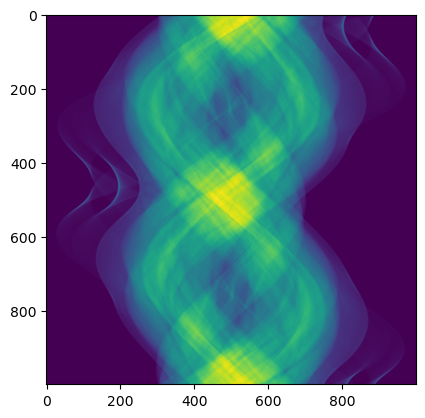

In [36]:
plt.imshow(sino_true_training_torch[2167,:,:].detach().cpu())

In [37]:
#image_true_val_np = np.load('/mnt/datahd/Hamidreza/Mayo_data/image_true_val_HU_new.npy')
sino_true_val_np = np.load('/mnt/datahd/Hamidreza/Mayo_data/sino_true_val_HU_new.npy')
sino_noisy_val_np = np.load('/mnt/datahd/Hamidreza/Mayo_data/sino_noisy_val_HU_new.npy')

#image_true_val_torch = torch.tensor(image_true_val_np)
sino_true_val_torch = torch.tensor(sino_true_val_np)
sino_noisy_val_torch = torch.tensor(sino_noisy_val_np)

In [38]:
del sino_true_val_np
del sino_noisy_val_np

In [39]:
sino_noisy_val_torch.shape

torch.Size([210, 1000, 1000])

In [40]:
sino_true_val_torch.squeeze(0).shape

torch.Size([210, 1000, 1000])

In [41]:
sino_noisy_val_torch[0].cpu().numpy().shape

(1000, 1000)

In [42]:
# Initialize accumulators for PSNR and SSIM
model.eval() 

total_psnr = 0.0
total_ssim = 0.0

# Loop over all samples in the validation set
with torch.no_grad():
    for i in range(210):
        # Get the model input and target for the current sample
        model_input = to_device(sino_noisy_val_torch[i], dev)
        target = to_device(sino_true_val_torch[i], dev)
        
        # Get the model output
        model_output = (model(model_input.unsqueeze(0).unsqueeze(1))).squeeze().squeeze()
        
        # Calculate PSNR and SSIM for the current sample
        psnr_value = fom.psnr(model_output.cpu().numpy(), target.cpu().numpy())
        ssim_value = fom.ssim(model_output.cpu().numpy(), target.cpu().numpy())
        
        # Accumulate the PSNR and SSIM values
        total_psnr += psnr_value
        total_ssim += ssim_value

# Calculate the mean PSNR and SSIM
mean_psnr = total_psnr / 210
mean_ssim = total_ssim / 210

# Print the mean PSNR and SSIM values
print("Mean PSNR: {:.3f}; Mean SSIM: {:.3f}".format(mean_psnr, mean_ssim))

Mean PSNR: 28.755; Mean SSIM: 0.596


In [43]:
model_output.shape

torch.Size([1000, 1000])

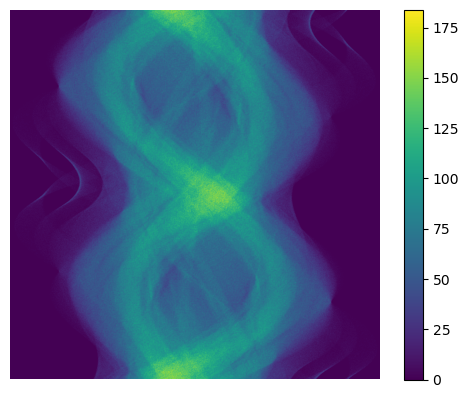

In [44]:
plt.imshow(model_output.cpu().numpy())
plt.colorbar()
ax = plt.gca()
ax.set_axis_off()

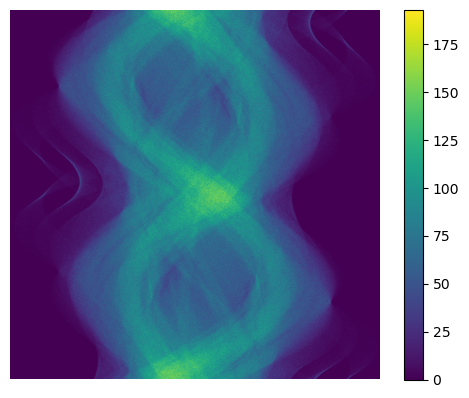

In [45]:
plt.imshow(model_input.cpu().numpy())
plt.colorbar()
ax = plt.gca()
ax.set_axis_off()

In [46]:
# np.save('first_result_output', model_output[:,:].cpu().numpy())
# np.save('first_result_input', model_input.cpu().numpy())
# np.save('first_result_target_sinogram', target.cpu().numpy())

In [47]:
# np.save('first_result_target_image', image_true_val_np[209,:,:])